In [1]:
import re
import sys
import yaml
import torch
import torchvision
from tqdm import tqdm
from warp_core.utils import load_or_fail

sys.path.append("..")
from utils import *
from train import WurstCoreB

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [2]:
# SETUP STAGE B & A
config_file_b = '../configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core_b = WurstCoreB(config_dict=config_file_b, device=device, training=False)

In [3]:
extras = warpcore.setup_extras_pre()
data = warpcore.setup_data(extras)
models = warpcore.setup_models(extras)
models.generator.bfloat16()
print("STAGE B READY")

Training with batch size 4 (4/GPU)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

STAGE B READY


In [ ]:
# PREVIEW BATCH
batch = next(data.iterator)
print("ORIG SIZE:", batch['images'].shape)

plt.figure(figsize=(24, 24))
plt.axis("off")
plt.imshow(torch.cat([
    torch.cat([i for i in batch['images'].clamp(0, 1)], dim=-1),
], dim=-2).permute(1, 2, 0).cpu())
plt.show()

print(batch['captions'][0])

SCALED SIZE: torch.Size([4, 3, 768, 768])
torch.Size([4, 16, 24, 24])
torch.Size([4, 4, 256, 256]) torch.Size([4, 3, 1024, 1024])


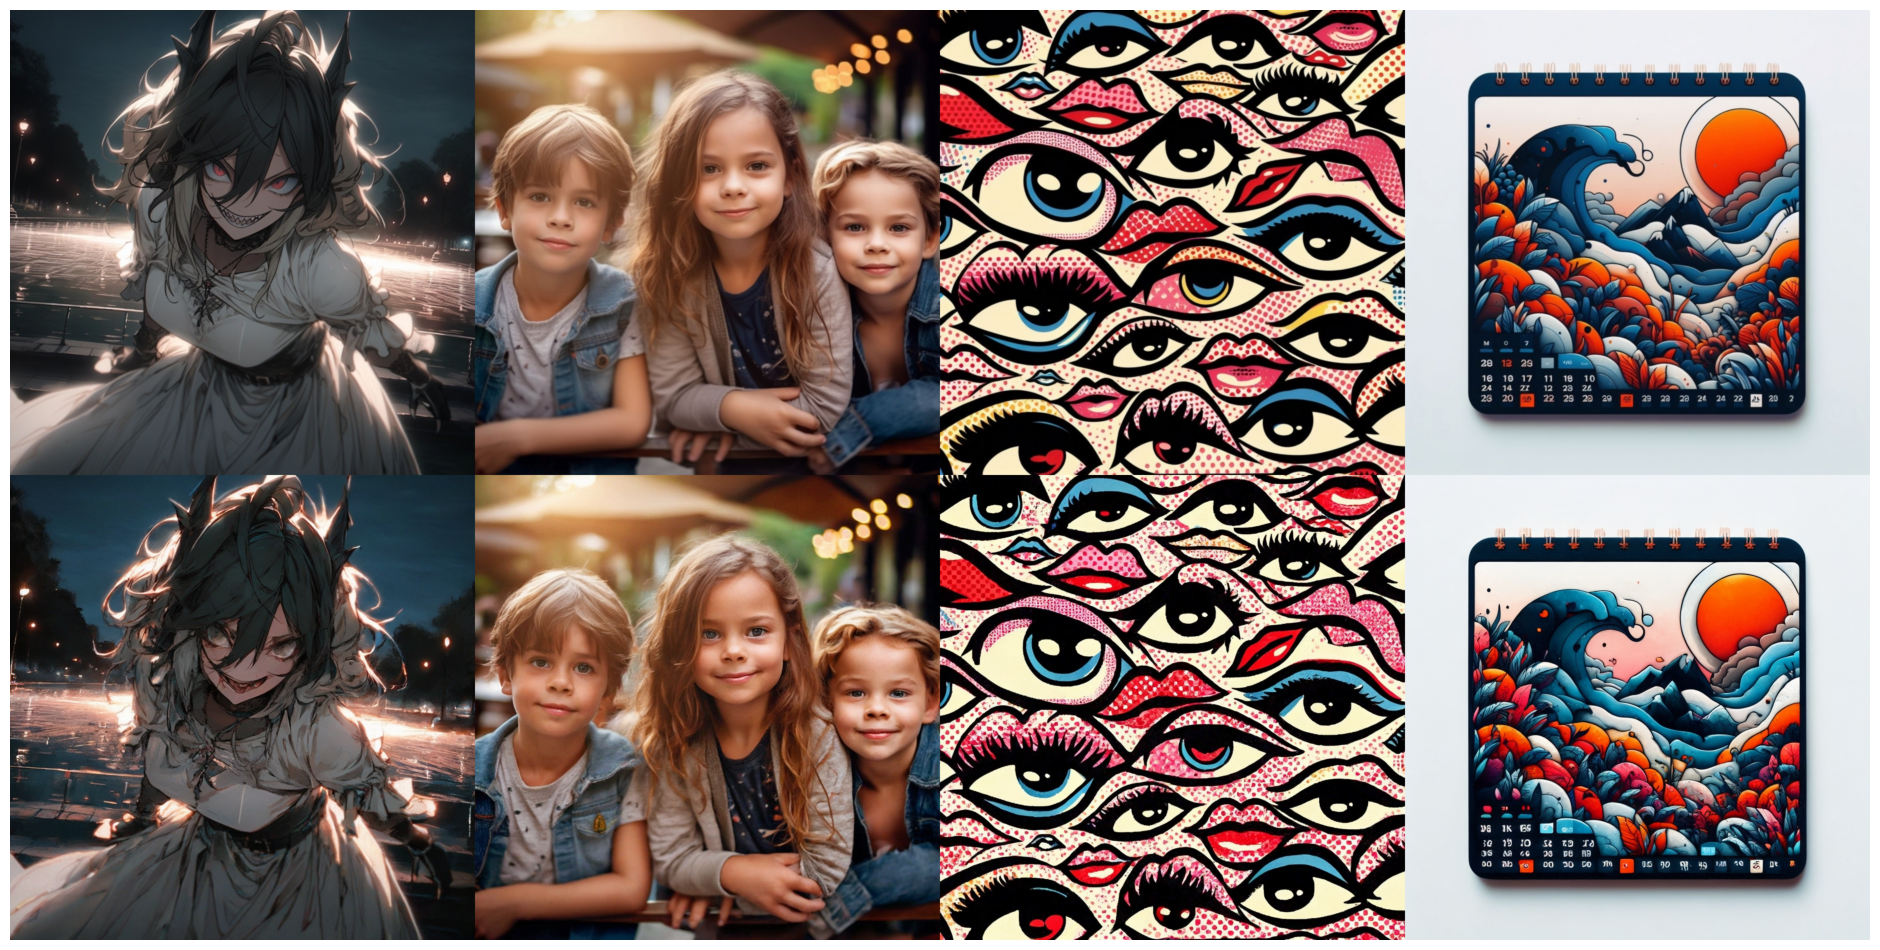

In [36]:
# Stage B Parameters
extras_b.sampling_configs['cfg'] = 1.1
extras_b.sampling_configs['shift'] = 1
extras_b.sampling_configs['timesteps'] = 10
extras_b.sampling_configs['t_start'] = 1.0

with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
    torch.manual_seed(42)
    
    effnet_factor = 3/4
    effnet_height, effnet_width = int(((batch['images'].size(-2)*effnet_factor)//32)*32), int(((batch['images'].size(-1)*effnet_factor)//32)*32)
    scaled_image = torchvision.transforms.functional.resize(batch['images'], (effnet_height, effnet_width), interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    print("SCALED SIZE:", scaled_image.shape)
    
    effnet_latents = models.effnet(extras.effnet_preprocess(scaled_image.to(device)))
    print(effnet_latents.shape)
    
    conditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=False, eval_image_embeds=False)
    unconditions = warpcore.get_conditions(batch, models, extras, is_eval=True, is_unconditional=True, eval_image_embeds=False)    
    conditions['effnet'] = effnet_latents
    unconditions['effnet'] = torch.zeros_like(effnet_latents)

    sampling_b = extras.gdf.sample(
        models.generator, conditions, (batch['images'].size(0), 4, batch['images'].size(-2)//4, batch['images'].size(-1)//4),
        unconditions, device=device, **extras.sampling_configs
    )
    for (sampled_b, _, _) in tqdm(sampling_b, total=extras_b.sampling_configs['timesteps']):
        sampled_b = sampled_b
    sampled_b = models_b.stage_a.decode(sampled_b).float()
        
show_images(batch['images'])
show_images(sampled_b)